# Pet breed detection with ResNet50 and Inception

## Data import and discovery

### Library and data import

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

import numpy as np
from numpy import round, sqrt, random
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dataset, info = tfds.load('oxford_iiit_pet',split=['train[:80%]', 'train[80%:]','test'], as_supervised=True, with_info=True)
train_set_raw, valid_set_raw, test_set_raw = dataset

# Create a dictionary of numerical label - breed key-value pairs
labels = info.features['label'].names                       # Name of the breed
label_dict = {i: breed for i,breed in enumerate(labels)}    # Dict comprehension to create key-value pairs of number-breed name
print(label_dict)

# Find out about the pixel value range
for image,_ in train_set_raw.take(1):
    print(f"Pixel value range: [{tf.reduce_min(image).numpy()}, {tf.reduce_max(image).numpy()}]")

# Number of classes
num_classes = info.features['label'].num_classes
print(f"There are {num_classes} classes of dogs and cats in this dataset")

c:\Users\caomi\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{0: 'Abyssinian', 1: 'american_bulldog', 2: 'american_pit_bull_terrier', 3: 'basset_hound', 4: 'beagle', 5: 'Bengal', 6: 'Birman', 7: 'Bombay', 8: 'boxer', 9: 'British_Shorthair', 10: 'chihuahua', 11: 'Egyptian_Mau', 12: 'english_cocker_spaniel', 13: 'english_setter', 14: 'german_shorthaired', 15: 'great_pyrenees', 16: 'havanese', 17: 'japanese_chin', 18: 'keeshond', 19: 'leonberger', 20: 'Maine_Coon', 21: 'miniature_pinscher', 22: 'newfoundland', 23: 'Persian', 24: 'pomeranian', 25: 'pug', 26: 'Ragdoll', 27: 'Russian_Blue', 28: 'saint_bernard', 29: 'samoyed', 30: 'scottish_terrier', 31: 'shiba_inu', 32: 'Siamese', 33: 'Sphynx', 34: 'staffordshire_bull_terrier', 35: 'wheaten_terrier', 36: 'yorkshire_terrier'}
Pixel value range: [0, 255]
There are 37 classes of dogs and cats in this dataset


### Input data visualization

In this section, I will visualize the images and labels from the dataset

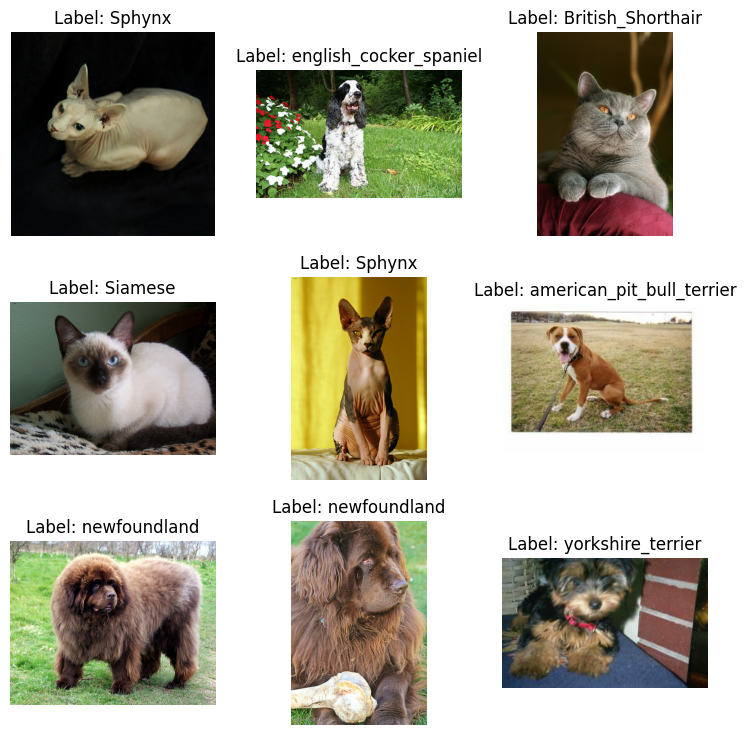

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

In [3]:
num_samples = 9
num_rows = int(round(sqrt(num_samples))); num_cols = int(num_samples/num_rows)
index = 1
plt.figure(figsize=(num_rows*3,num_cols*3))

# Display some images from the raw train set
for image, label in train_set_raw.take(num_samples):
    # print(image)
    plt.subplot(num_rows,num_cols,index)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Label: {label_dict[label.numpy()]}")
    plt.axis("off")
    index += 1
plt.show()
plt.tight_layout

### Examine the image dimensions
As can be seen from the visualization above, each iamge has a unique size. I ahve created the function below to determine the minimum height and width resolution of the images in the train, validation, and test set

In [4]:
def find_min_resolution(dataset):

    min_height = float('inf')
    min_width = float('inf')
    for image, _ in dataset:
        height,width,_ = image.shape

        min_height = min(min_height,height)
        min_width = min(min_width,width)

    print(f"The minimum height resolution: {min_height}\n"
          f"The minimum width resolution: {min_width}")
    
find_min_resolution(train_set_raw)
find_min_resolution(valid_set_raw)
find_min_resolution(test_set_raw)


The minimum height resolution: 108
The minimum width resolution: 114
The minimum height resolution: 112
The minimum width resolution: 150
The minimum height resolution: 103
The minimum width resolution: 137


### Image resizing
So the minimum height resolution is 103 and the minimum width resolution is 114. I will resize the images to have dimension of (224,224) for the pretrained pre-trained ResNet50 network. Normally, I would include the iamge preprocessing step inside the final model. However, given the variety of image dimensions, I will have to resize the images first

In [5]:
def preprocess_image(image,target_size = (96, 96),
                     display=False,
                     pad=True):
    '''This function resize an image while keeping the aspect ratio such that the shorter side is 96 pixels (by default)'''
    
    if pad:     # Resize with padding (shrink the image while preserving aspect ratio and fill void with black)
        image = tf.image.resize_with_pad(image, target_size[0],target_size[1])
    else:       # Resize without padding - stretch or shrink the image to the desired target size 
        image = tf.image.resize(image, target_size)

    return image

def preprocess_dataset(dataset, target_size = (96,96),display=False,pad=True):
    '''This function applies the preprocess_image() on the images in a dataset to resize the iamges to the target_size (default 96x96)'''
    return dataset.map(lambda image, label: (preprocess_image(image,target_size,display,pad), label))

# The desired size for the processed images
TARGET_SIZE = (224,224)
train_set_processed = preprocess_dataset(train_set_raw,target_size=TARGET_SIZE)
valid_set_processed = preprocess_dataset(valid_set_raw,target_size=TARGET_SIZE)
test_set_processed = preprocess_dataset(test_set_raw,target_size=TARGET_SIZE)

train_set_processed_display = preprocess_dataset(train_set_raw,target_size=TARGET_SIZE,display=True)

find_min_resolution(train_set_processed_display)


The minimum height resolution: 224
The minimum width resolution: 224


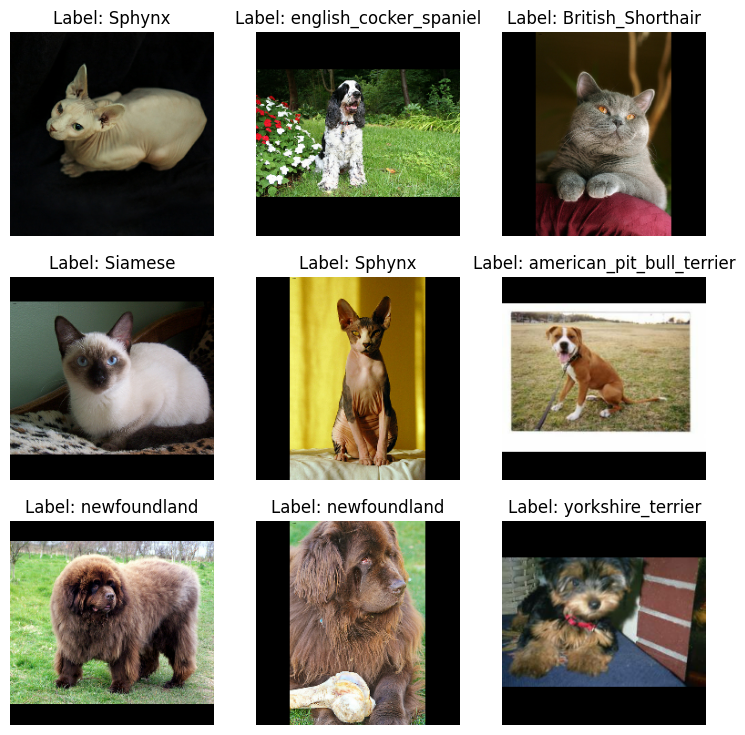

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

In [6]:
num_samples = 9
num_rows = int(round(sqrt(num_samples))); num_cols = int(num_samples/num_rows)
index = 1
plt.figure(figsize=(num_rows*3,num_cols*3))

# Display some images from the raw train set
for image, label in train_set_processed_display.take(num_samples):
    # # Examine the range of pixel value
    # print("Pixel value range:", tf.reduce_min(image).numpy(), "to", tf.reduce_max(image).numpy())
    
    plt.subplot(num_rows,num_cols,index)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Label: {label_dict[label.numpy()]}")
    plt.axis("off")
    index += 1
plt.show()
plt.tight_layout

### Dataset => nparray Conversion
In this code block, I define a function to extract the image and label data from any of the three datasets. This make it easier to work with the data in the form of numpy arrays instead of PrefetchDataset objects when importing the dataset from tensorflow.

Since the dataset has images of different dimensions, this function will also resize the images to a 

In [7]:
def get_nparray_dataset(dataset):
    image_list = []
    label_list = []

    for image,label in dataset:
        image_list.append(image.numpy())
        label_list.append(label.numpy())

    image_list_npararay = np.array(image_list)
    label_list_nparray = np.array(label_list)
    
    return image_list_npararay, label_list_nparray

In [8]:
train_image_array, train_label_array = get_nparray_dataset(train_set_processed)
valid_image_array, valid_label_array = get_nparray_dataset(valid_set_processed)
test_image_array, test_label_array = get_nparray_dataset(test_set_processed)

print(train_image_array.shape, train_label_array.shape)
print(valid_image_array.shape, valid_label_array.shape)
print(test_image_array.shape, test_label_array.shape)

num_train = len(train_label_array)
num_valid = len(valid_label_array)
num_test = len(test_image_array)

(2944, 224, 224, 3) (2944,)
(736, 224, 224, 3) (736,)
(3669, 224, 224, 3) (3669,)


### nparray => Data Generator conversion
I found that when training or evaluating a model on a GPU with limited RAM (such as 8GB RAM cards like the T1000 or RTX4060), the code often fails since TensorFlow tries to load the full arrays into the GPU memory (even when loading in batches). This code block is an attempt to solve this problem by using a generator to generate data from the training sets to the model in batches

In [26]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
BATCH_SIZE = 32

# These generator objects will generate 32 data at a time from the specified nparray's
train_gen = DataGenerator(train_image_array,train_label_array,BATCH_SIZE)
valid_gen = DataGenerator(valid_image_array,valid_label_array,BATCH_SIZE)
test_gen = DataGenerator(test_image_array,test_label_array,BATCH_SIZE)

## ResNet50-based model


### Base model construction

In [27]:
base_model = ResNet50(weights='imagenet',
                    #   input_shape=TARGET_SIZE+(3,),
                      include_top=False)

# Freeze the weights of the model
base_model.trainable = False

# # Investigate the structure of the base model and make sure that the weights are frozen
# base_model.summary()

### Full model architecture

In [28]:
model_resnet = models.Sequential([
    layers.Input(shape=TARGET_SIZE + (3,)),
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Output layer for pet breeds
])

initial_weights = model_resnet.get_weights()

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 37)                7

### Model Training

In [29]:
LR = 0.001

tf.keras.backend.clear_session()
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                     
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
loss0, acc0 = model_resnet.evaluate(test_gen,batch_size=BATCH_SIZE)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))
tf.keras.backend.clear_session()

115/115 [==============================] - 9s 69ms/step - loss: 3.9243 - accuracy: 0.0278
initial loss: 3.92
initial accuracy: 0.03


In [30]:
# Train the model with the base layers frozen
initial_epochs = 10
model_resnet.set_weights(initial_weights)

history_resnet = model_resnet.fit(train_gen, 
                                  validation_data=valid_gen, 
                                  epochs=initial_epochs)


Epoch 1/10
92/92 [==============================] - 10s 91ms/step - loss: 3.4398 - accuracy: 0.1834 - val_loss: 1.7909 - val_accuracy: 0.6712
Epoch 2/10
92/92 [==============================] - 8s 88ms/step - loss: 2.0269 - accuracy: 0.4042 - val_loss: 1.0383 - val_accuracy: 0.8098
Epoch 3/10
92/92 [==============================] - 8s 87ms/step - loss: 1.5961 - accuracy: 0.5085 - val_loss: 0.6976 - val_accuracy: 0.8410
Epoch 4/10
92/92 [==============================] - 8s 87ms/step - loss: 1.3387 - accuracy: 0.5921 - val_loss: 0.5426 - val_accuracy: 0.8560
Epoch 5/10
92/92 [==============================] - 8s 87ms/step - loss: 1.1516 - accuracy: 0.6335 - val_loss: 0.4675 - val_accuracy: 0.8601
Epoch 6/10
92/92 [==============================] - 8s 88ms/step - loss: 1.0797 - accuracy: 0.6596 - val_loss: 0.4512 - val_accuracy: 0.8601
Epoch 7/10
92/92 [==============================] - 8s 88ms/step - loss: 1.0095 - accuracy: 0.6709 - val_loss: 0.4078 - val_accuracy: 0.8723
Epoch 8/10
9

In [17]:
def plot_performance(history, learning_rate=None, batch_size=None, finetune_epochs=None):
  plt.figure(figsize=(10,5))

  # history_data = history.history

  # Determine whether history is keras history or a dictionary to appropriately extract the history data
  if isinstance(history, keras.callbacks.History):
    history_data = history.history        # Extract the history dictionary
  else:
    history_data = history                # Assume it's already a dictionary

  # Accuracy of model training and validation vs training epoch
  plt.subplot(1,2,1)
  ylim_acc = [0, max(max(history_data['accuracy']),max(history_data['val_accuracy']))]
  plt.plot(history_data['accuracy'], label = 'Training accuracy')
  plt.plot(history_data['val_accuracy'], label = 'Validation accuracy')
  plt.ylim(ylim_acc)
  if finetune_epochs:
    plt.plot([finetune_epochs-1, finetune_epochs-1],plt.ylim(), label = 'Fine tuning')
  else:
    pass

  if learning_rate and batch_size:
    plt.title(f'Model accuracy \n lr = {learning_rate}, batch size = {batch_size}')
  else: plt.title('Model accuracy')

  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')

  # Loss during model training and validation
  plt.subplot(1,2,2)
  ylim_loss = [0, max(max(history_data['loss']),max(history_data['val_loss']))]
  # print(len(history_data['loss']))
  plt.plot(history_data['loss'], label = 'Training loss')
  plt.plot(history_data['val_loss'], label = 'Validation loss')
  plt.ylim(ylim_loss)
  if finetune_epochs:
    plt.plot([finetune_epochs-1, finetune_epochs-1],plt.ylim(), label = 'Fine tuning')
  else:
    pass

  if learning_rate and batch_size:
    plt.title(f'Model loss \n lr = {learning_rate}, batch size = {batch_size}')
  else: plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

  print(f"The model has a training accuracy of {history_data['accuracy'][-1]*100:.2f}%\n"
      f"The model has a validation accuracy of {history_data['val_accuracy'][-1]*100:.2f}%")
  return

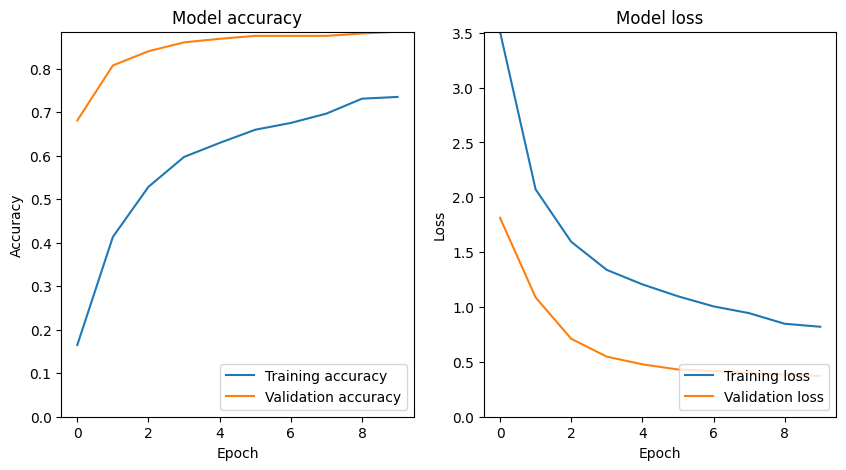

The model has a training accuracy of 73.47%
The model has a validation accuracy of 88.45%


In [18]:
plot_performance(history_resnet)

### Model Evaluation

In [21]:
test_loss, test_acc = model_resnet.evaluate(test_gen,batch_size=BATCH_SIZE)
print(f"Test accuracy: {test_acc}\n"
      f"Test loss: {test_loss}")

115/115 [==============================] - 8s 69ms/step - loss: 0.4190 - accuracy: 0.8700
Test accuracy: 0.8699918389320374
Test loss: 0.41895541548728943


In [22]:
# prediction_array = np.argmax(model_resnet.predict(test_image_array), axis=1)
prediction_array = np.argmax(model_resnet.predict(test_image_array,batch_size=BATCH_SIZE), axis=1)

115/115 [==============================] - 7s 58ms/step


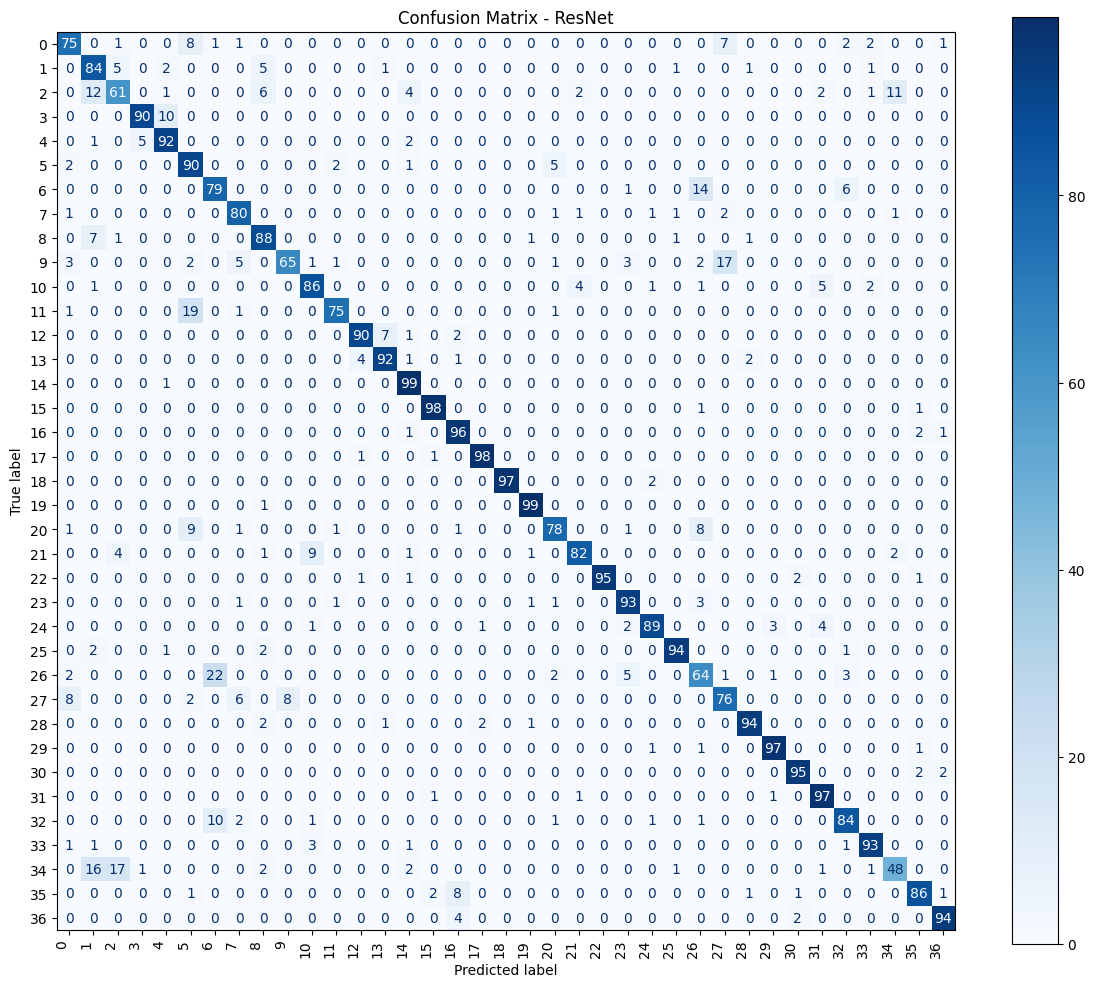

{0: 'Abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'Bengal',
 6: 'Birman',
 7: 'Bombay',
 8: 'boxer',
 9: 'British_Shorthair',
 10: 'chihuahua',
 11: 'Egyptian_Mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'Maine_Coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'Persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'Ragdoll',
 27: 'Russian_Blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'Siamese',
 33: 'Sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}

In [25]:
cm = confusion_matrix(test_label_array, prediction_array)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # You can change the color map as desired
fig = disp.ax_.get_figure() 
fig.set_figwidth(12); fig.set_figheight(10) 
plt.title("Confusion Matrix - ResNet")
plt.xticks(rotation=90, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Keep y labels horizontal
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

label_dict

### Model Prediction and Visualization

1/1 [==============================] - 1s 834ms/step


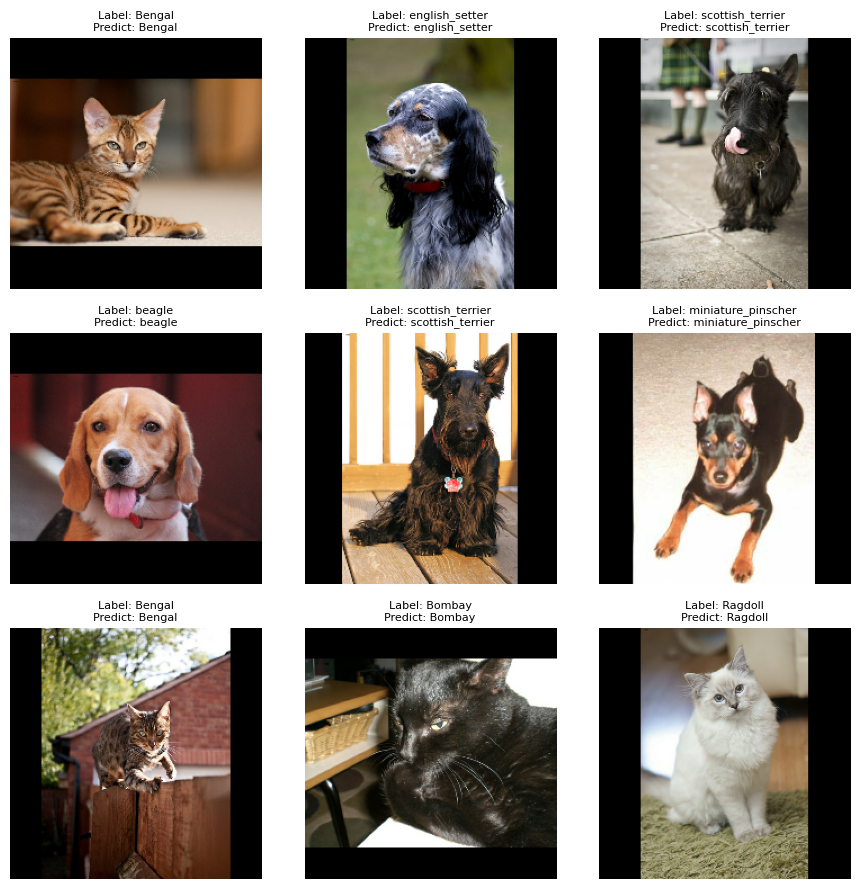

In [31]:
# Sample random images and their indices
num_samples = 9                                                                             # number of samples to be display
num_rows = int(round(sqrt(num_samples))); num_cols = int(num_samples/num_rows)      # number of rows and columns for the subplot
rand = random.randint(num_test,size = (num_samples))                                       # random index for choosing the samples in the dataset

image_test_rand_array = test_image_array[rand]
label_test_rand_array = test_label_array[rand]
prediction_rand_array = np.argmax(model_resnet.predict(image_test_rand_array),axis=1)

plt.figure(figsize=(num_rows*3,num_cols*3))
# fig, axes1 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols2))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        plt.subplot(num_rows,num_cols,index+1)
        image = image_test_rand_array[index]/255.0  # Extract the image
        label = label_test_rand_array[index]  # Extract the label
        prediction = prediction_rand_array[index]

        # Original pictures (no augmentation layer applied)
        plt.axis("off")
        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {label_dict[label]}\n"
                  f"Predict: {label_dict[prediction]}",
                  fontsize = 8) 

plt.tight_layout()

## InceptionV3-based model

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

Since the inception model use similar input image shapes as ResNet, I will reuse the processed train, validation, and test sets

### Base Model Construction

In [33]:

base_model = InceptionV3(weights='imagenet',
                         include_top=False)

# Freeze the weights of the model
base_model.trainable = False

# # Investigate the structure of the base model and make sure that the weights are frozen
# base_model.summary()

### Full Model

In [34]:
model_inception = models.Sequential([
    layers.Input(TARGET_SIZE + (3,)),
    layers.Lambda(inception_preprocess),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')  # Use 1 for binary classification (dogs vs cats)
])

initial_weight_inception = model_inception.get_weights()

model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 37)                7

### Model Training

In [36]:
model_inception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=["accuracy"])


loss0, acc0 = model_inception.evaluate(test_gen, batch_size=BATCH_SIZE)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))

115/115 [==============================] - 7s 51ms/step - loss: 3.9003 - accuracy: 0.0365
initial loss: 3.90
initial accuracy: 0.04


In [37]:
# Train the model with the base layers frozen
initial_epochs = 10
model_inception.set_weights(initial_weight_inception)
history_inception = model_inception.fit(train_gen, 
                                        validation_data=valid_gen,
                                        epochs=initial_epochs,
                                        batch_size=32)

Epoch 1/10
92/92 [==============================] - 9s 64ms/step - loss: 2.9050 - accuracy: 0.2840 - val_loss: 1.4924 - val_accuracy: 0.7405
Epoch 2/10
92/92 [==============================] - 6s 64ms/step - loss: 1.6109 - accuracy: 0.5465 - val_loss: 0.8727 - val_accuracy: 0.8179
Epoch 3/10
92/92 [==============================] - 6s 65ms/step - loss: 1.3267 - accuracy: 0.6168 - val_loss: 0.6633 - val_accuracy: 0.8274
Epoch 4/10
92/92 [==============================] - 6s 64ms/step - loss: 1.1458 - accuracy: 0.6590 - val_loss: 0.5720 - val_accuracy: 0.8492
Epoch 5/10
92/92 [==============================] - 6s 64ms/step - loss: 0.9996 - accuracy: 0.6960 - val_loss: 0.5327 - val_accuracy: 0.8519
Epoch 6/10
92/92 [==============================] - 6s 64ms/step - loss: 0.8767 - accuracy: 0.7330 - val_loss: 0.5288 - val_accuracy: 0.8519
Epoch 7/10
92/92 [==============================] - 6s 64ms/step - loss: 0.8463 - accuracy: 0.7463 - val_loss: 0.4976 - val_accuracy: 0.8573
Epoch 8/10
92

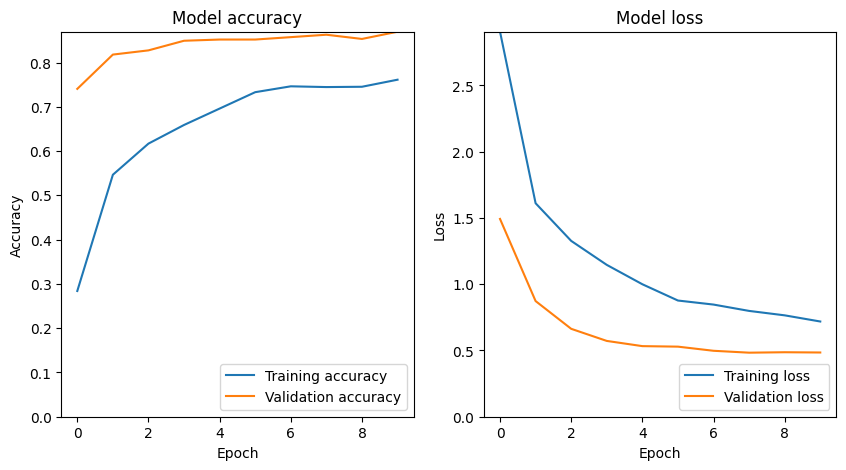

The model has a training accuracy of 76.12%
The model has a validation accuracy of 86.96%


In [38]:
plot_performance(history_inception)

### Model Evaluation

In [42]:
test_loss_inception, test_acc_inception = model_inception.evaluate(test_gen)
print(f"Test accuracy: {test_acc}\n"
      f"Test loss: {test_loss}")

prediction_array_inception = np.argmax(model_inception.predict(test_gen), axis=1)


115/115 [==============================] - 6s 52ms/step - loss: 0.4393 - accuracy: 0.8629
Test accuracy: 0.8699918389320374
Test loss: 0.41895541548728943
115/115 [==============================] - 6s 49ms/step


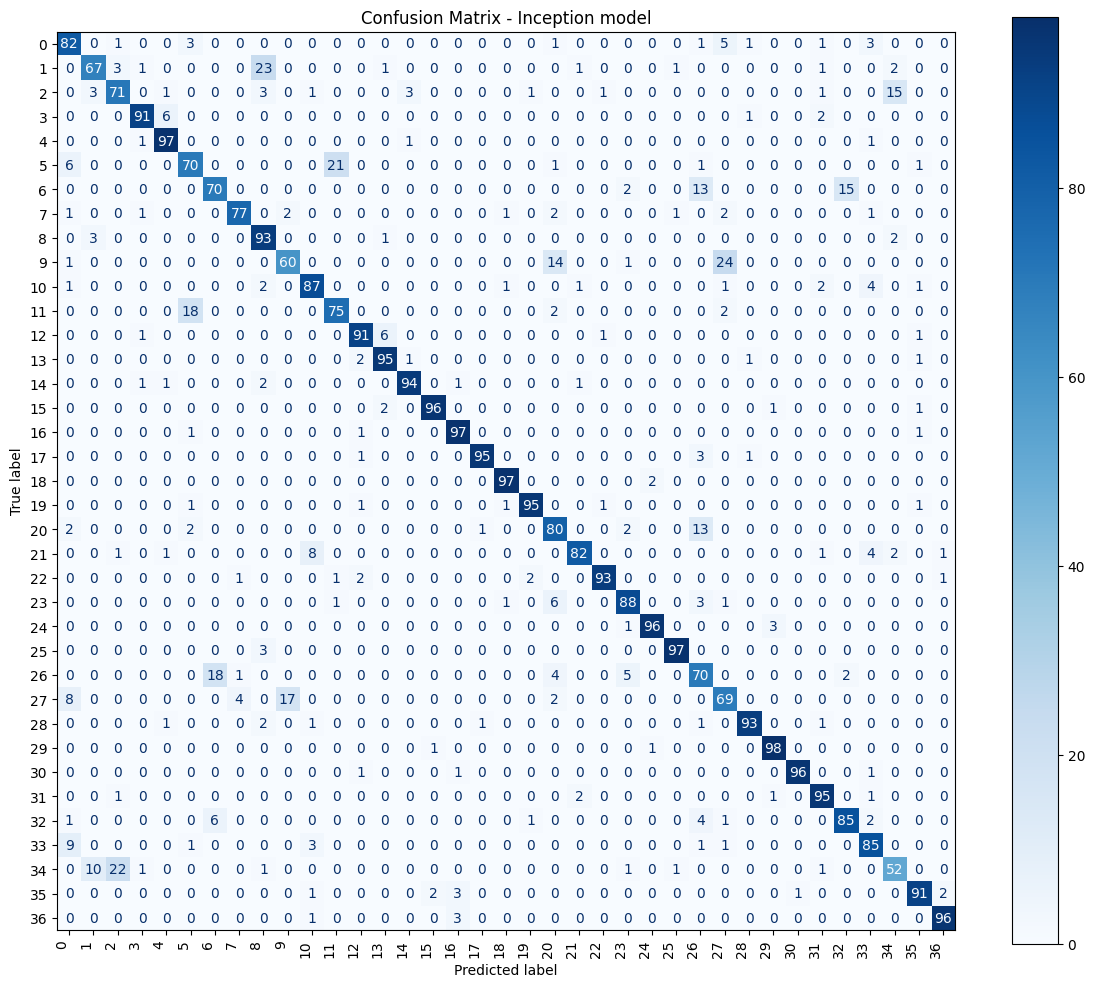

{0: 'Abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'Bengal',
 6: 'Birman',
 7: 'Bombay',
 8: 'boxer',
 9: 'British_Shorthair',
 10: 'chihuahua',
 11: 'Egyptian_Mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'Maine_Coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'Persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'Ragdoll',
 27: 'Russian_Blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'Siamese',
 33: 'Sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}

In [61]:
cm = confusion_matrix(test_label_array, prediction_array_inception)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # You can change the color map as desired
fig = disp.ax_.get_figure() 
fig.set_figwidth(12)
fig.set_figheight(10) 
plt.title("Confusion Matrix - Inception model")
plt.xticks(rotation=90, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Keep y labels horizontal
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

label_dict

### Model Prediction and Visualization

1/1 [==============================] - 0s 41ms/step


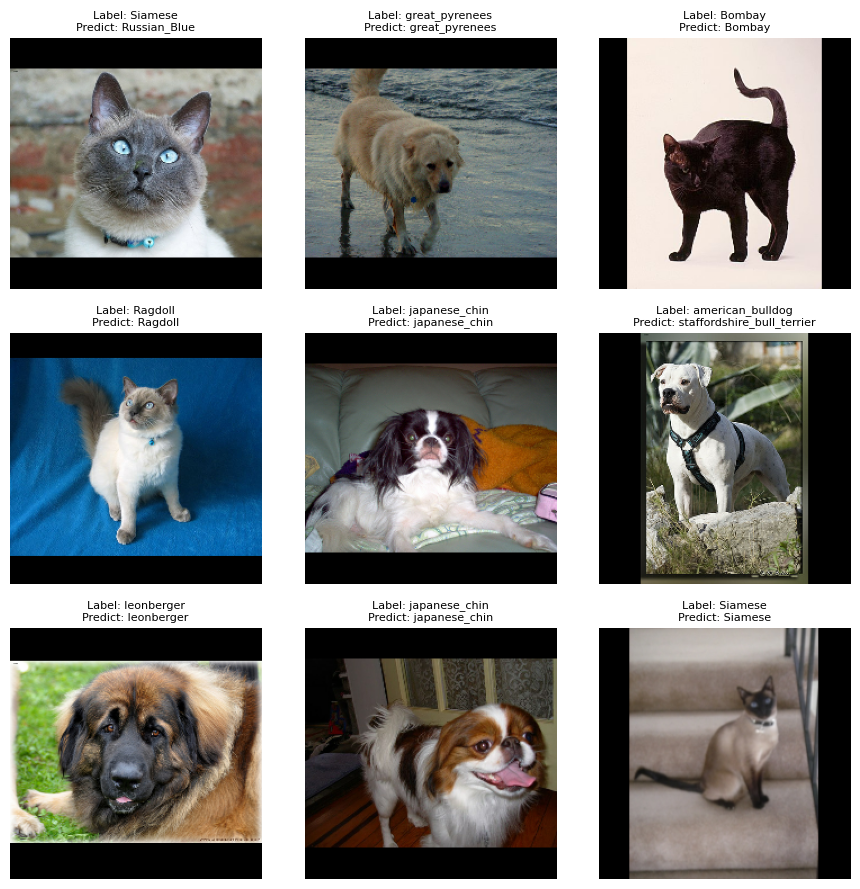

In [63]:
# Sample random images and their indices
num_samples = 9                                                                             # number of samples to be display
num_rows = int(round(sqrt(num_samples))); num_cols = int(num_samples/num_rows)      # number of rows and columns for the subplot
rand = random.randint(num_test,size = (num_samples))                                       # random index for choosing the samples in the dataset

image_test_rand_array = test_image_array[rand]
label_test_rand_array = test_label_array[rand]
data_rand_gen = DataGenerator(image_test_rand_array,label_test_rand_array,batch_size=BATCH_SIZE)
prediction_rand_array = np.argmax(model_inception.predict(data_rand_gen),axis=1)

plt.figure(figsize=(num_rows*3,num_cols*3))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        plt.subplot(num_rows,num_cols,index+1)
        image = image_test_rand_array[index]/255.0  # Extract the image
        label = label_test_rand_array[index]  # Extract the label
        prediction = prediction_rand_array[index]

        # Original pictures (no augmentation layer applied)
        plt.axis("off")
        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {label_dict[label]}\n"
                  f"Predict: {label_dict[prediction]}",
                  fontsize = 8) 

plt.tight_layout()

## ResNet vs Inception Comparison

### Model Performance Comparison

In [65]:
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_gen)
test_loss_inception, test_acc_inception = model_inception.evaluate(test_gen)

print(test_acc_resnet, test_loss_resnet)
print(test_acc_inception, test_loss_inception)

115/115 [==============================] - 6s 51ms/step - loss: 0.4393 - accuracy: 0.8629
0.8582720160484314 0.42898058891296387
0.8629054427146912 0.43929481506347656


In [66]:
msg_loss = "comparable"; msg_acc = "comparable"
test_loss_diff = test_loss_resnet - test_loss_inception
test_acc_diff = test_acc_resnet - test_acc_inception
acc_diff_threshold = 0.01; loss_diff_threshold = 0.01

if np.abs(test_loss_diff) > acc_diff_threshold:
    if test_loss_resnet > test_loss_inception: msg_loss = "better"
    else: msg_loss = "worse"

if np.abs(test_acc_diff) > loss_diff_threshold:
    if test_acc_resnet > test_acc_inception: msg_acc = "better"
    else: msg_acc = "worse"

print(f"The ResNet-based model has {msg_acc} accuracy compared to the Inception-based model\n"
      f"Resnet-based model accuracy: {test_acc_resnet*100:.2f}%\n"
      f"Inception-based model accuracy: {test_acc_inception*100:.2f}%")

print(f"The ResNet-based model has {msg_loss} accuracy compared to the Inception-based model\n"
      f"Resnet-based model loss: {test_loss_resnet:.2f}\n"
      f"Inception-based model loss: {test_loss_inception:.2f}")

The ResNet-based model has comparable accuracy compared to the Inception-based model
Resnet-based model accuracy: 85.83%
Inception-based model accuracy: 86.29%
The ResNet-based model has worse accuracy compared to the Inception-based model
Resnet-based model loss: 0.43
Inception-based model loss: 0.44


### Prediction Comparison

1/1 [==============================] - 0s 209ms/step


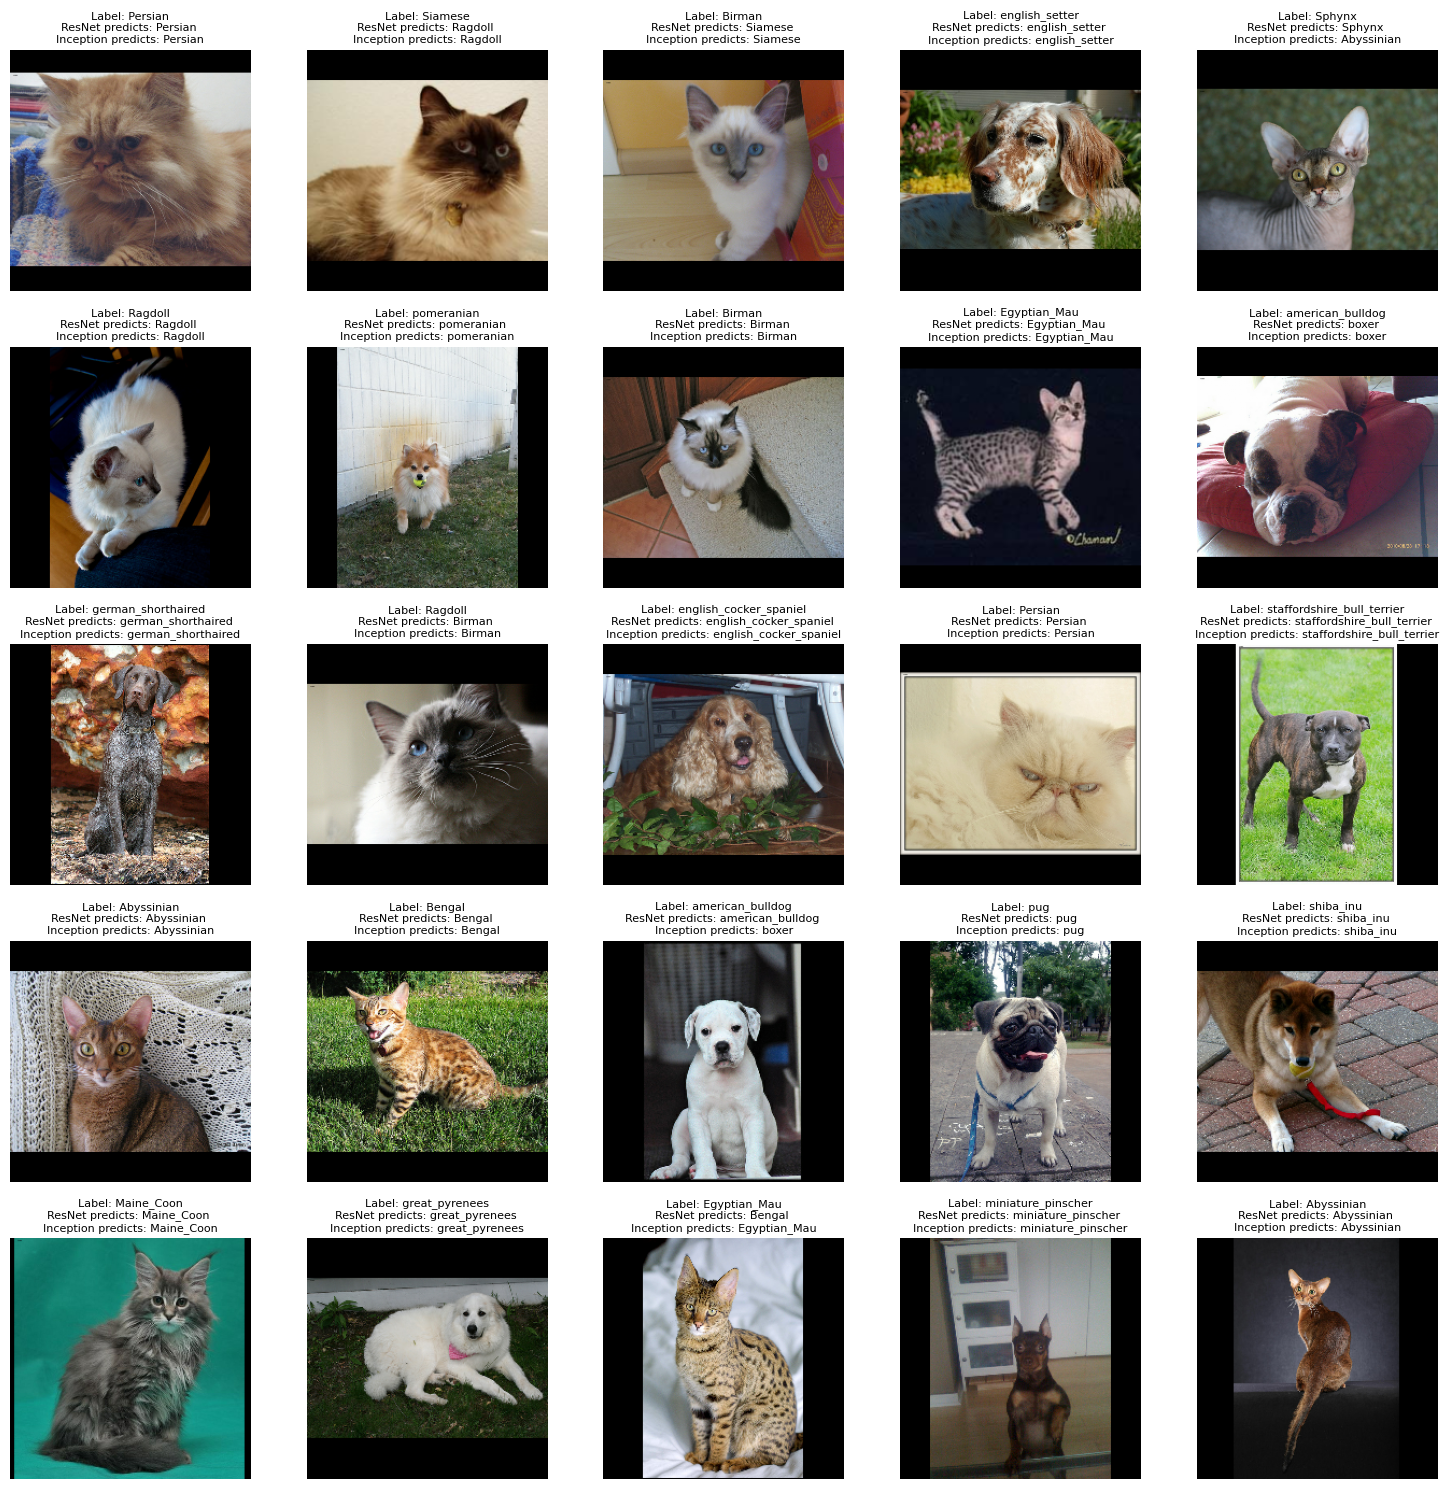

In [67]:
# Sample random images and their indices
num_samples = 25                                                                             # number of samples to be display
num_rows = int(round(sqrt(num_samples))); num_cols = int(num_samples/num_rows)      # number of rows and columns for the subplot
rand = random.randint(num_test,size = (num_samples))                                       # random index for choosing the samples in the dataset

image_test_rand_array = test_image_array[rand]
label_test_rand_array = test_label_array[rand]
prediction_rand_array_resnet = np.argmax(model_resnet.predict(image_test_rand_array),axis=1)
prediction_rand_array_inception = np.argmax(model_inception.predict(image_test_rand_array),axis=1)

plt.figure(figsize=(num_rows*3,num_cols*3))
# fig, axes1 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols2))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        plt.subplot(num_rows,num_cols,index+1)
        image = image_test_rand_array[index]/255.0      # Extract the image
        label = label_test_rand_array[index]            # Extract the label
        prediction_resnet = prediction_rand_array_resnet[index]
        prediction_inception = prediction_rand_array_inception[index]

        # Original pictures (no augmentation layer applied)
        plt.axis("off")
        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {label_dict[label]}\n"
                  f"ResNet predicts: {label_dict[prediction_resnet]} \n"
                  f"Inception predicts: {label_dict[prediction_inception]}",
                  fontsize = 8) 

plt.tight_layout()